In [1]:
from pv_analysis import *

In [2]:
rad_file_path = 'data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_rad.csv'
temp_wind_file_path = 'data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_temp_wind.csv'
clear_minute_file_path = 'data/Clear_sky_minutes_kuopio_RH16.txt'

In [3]:
clear_days = find_clear_days('data/Clear_sky_minutes_kuopio_RH16.txt', print_results=True, threshold=0.8)

Total days analyzed: 132
Statistical Upper Bound: 649.50 lines/day
Number of statistically significant days: 20
------------------------------
Top Statistically Significant Days:
      Date  LineCount
2021-07-03        914
2021-07-04        872
2021-06-09        821
2021-06-11        801
2021-06-10        796
2021-05-13        796
2021-05-12        791
2021-06-04        781
2021-07-14        759
2021-07-26        747
2021-05-30        722
2021-06-29        722
2021-07-16        720
2021-06-02        719
2021-04-19        716
2021-04-17        710
2021-04-16        692
2021-07-02        664
2021-06-06        658
2021-07-27        657


In [4]:
# use tqdm to show progress
# for day in tqdm.tqdm(clear_days['Date'], desc="Processing clear days"):
#     # print(f"\nAnalyzing clear day: {day}")
#     df = get_extra_data(temp_wind_file_path, rad_file_path, day, '5min', 'h.dong-2@outlook.com')
#     # save to csv with datetiime as index
#     df.to_csv(f'output/extra_data_{day}.csv', index=True)
    # print(f"Saved extra data for {day} to output/extra_data_{day}.csv")

In [4]:
extra_data_df = pd.read_csv(f'output/extra_data_{clear_days["Date"].iloc[0]}.csv')
extra_data_df['timestamp'] = pd.to_datetime(extra_data_df['timestamp'])
extra_data_df = extra_data_df.set_index('timestamp')
extra_data_df.index.name = 'time'
extra_data_df = extra_data_df[['dni', 'dhi', 'ghi', 'T', 'wind', 'albedo']]
extra_data_df = extra_data_df.round(2)
print(extra_data_df.head())

                           dni   dhi   ghi      T  wind  albedo
time                                                           
2021-07-03 00:00:00+00:00  0.0  0.24 -0.56  16.90  1.40     0.2
2021-07-03 00:05:00+00:00  0.0  0.34 -0.14  16.84  1.40     0.2
2021-07-03 00:10:00+00:00  0.0  0.42  0.22  16.82  1.36     0.2
2021-07-03 00:15:00+00:00  0.0  1.00  1.58  16.62  1.32     0.2
2021-07-03 00:20:00+00:00  0.0  1.48  2.30  16.54  1.42     0.2


In [11]:
shadow_matrix_df = pd.read_csv('results/shadow_matrix_results_rebuild/shadow_attenuation_matrix_re_beta_2.08_size_2.0.csv', index_col=0)
# excel_df = pd.read_excel('data/pvdata/pv_21.xlsx')
file_path = 'data/pvdata/pv_21.xlsx'  # Replace with your filename
df = pd.read_excel(file_path, usecols=[0, 2], skiprows=[0, 1], header=None)
df.columns = ['Timestamp', 'Energy_Wh']
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)

# Convert to datetime and scale values
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d.%m.%Y %H:%M')
df['Power_W'] = df['Energy_Wh'] * 12  # Energy to Power conversion for 5-min intervals


# pv_analysis(target_date=clear_days['Date'].iloc[0], shadow_matrix_df=shadow_matrix_df, excel_df=df, df_extra=extra_data_df, window_size=20, plot=True)

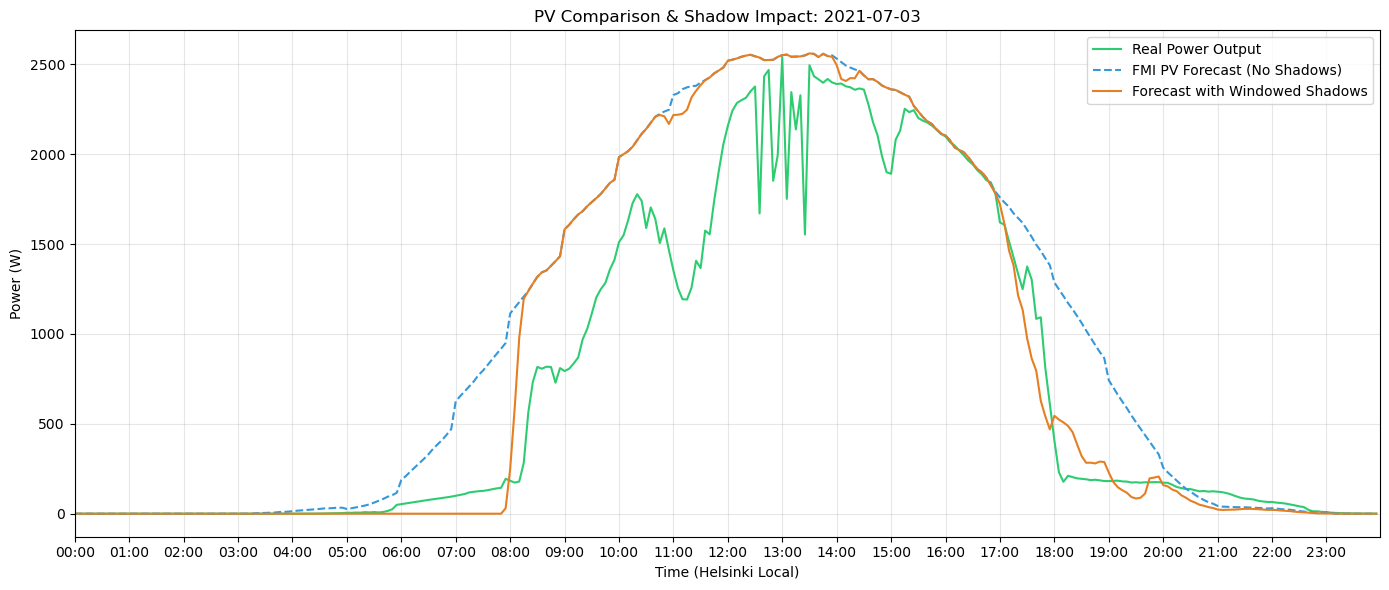

In [14]:
day_data, forecast_base, forecast_windowed = pv_analysis(target_date=clear_days['Date'].iloc[0], shadow_matrix_df=shadow_matrix_df, excel_df=df, df_extra=extra_data_df, window_size=(3, 20), plot=True)

In [7]:
performance_metrics = {
        'RMSE_Base': [],
        'RMSE_Shaded': [],
        'Real_Wh': 0.0,
        'Base_Wh': 0.0,
        'Shaded_Wh': 0.0
    }

In [8]:
shadow_matrix_df = pd.read_csv('results/shadow_matrix_results_re/shadow_attenuation_matrix_re.csv', index_col=0)
# excel_df = pd.read_excel('data/pvdata/pv_21.xlsx')
pv_file_path = 'data/pvdata/pv_21.xlsx'  # Replace with your filename
pv_df = pd.read_excel(pv_file_path, usecols=[0, 2], skiprows=[0, 1], header=None)
# df = pv_df.copy()
pv_df.columns = ['Timestamp', 'Energy_Wh']
pv_df['Timestamp'] = pd.to_datetime(pv_df['Timestamp'], dayfirst=True)

# Convert to datetime and scale values
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d.%m.%Y %H:%M')
pv_df['Power_W'] = pv_df['Energy_Wh'] * 12  # Energy to Power conversion for 5-min intervals


for day in tqdm.tqdm(clear_days['Date'], desc="Processing clear days"):
    extra_data_df = pd.read_csv(f'output/extra_data_{day}.csv')
    extra_data_df['timestamp'] = pd.to_datetime(extra_data_df['timestamp'])
    extra_data_df = extra_data_df.set_index('timestamp')
    extra_data_df.index.name = 'time'
    extra_data_df = extra_data_df[['dni', 'dhi', 'ghi', 'T', 'wind', 'albedo']]
    extra_data_df = extra_data_df.round(2)
    day_data, forecast_base, forecast_windowed = pv_analysis(target_date=day, shadow_matrix_df=shadow_matrix_df, excel_df=pv_df, df_extra=extra_data_df, window_size=20, plot=False)
    metrics = compute_metrics(day_data, forecast_base, forecast_windowed)
    performance_metrics['RMSE_Base'].append(metrics['RMSE_Base'])
    performance_metrics['RMSE_Shaded'].append(metrics['RMSE_Shaded'])
    performance_metrics['Real_Wh'] += metrics['Real_Wh']
    performance_metrics['Base_Wh'] += metrics['Base_Wh']
    performance_metrics['Shaded_Wh'] += metrics['Shaded_Wh']

Processing clear days: 100%|██████████| 20/20 [00:00<00:00, 32.80it/s]


In [14]:
def print_performance_metrics(performance_metrics):

    print("\nOverall Performance Metrics Across All Clear Days:")
    print(f"Average RMSE of Baseline Forecast: {np.mean(performance_metrics['RMSE_Base']):.2f} W")
    print(f"Average RMSE of Shaded Forecast: {np.mean(performance_metrics['RMSE_Shaded']):.2f} W")
    print(f"Total Real Energy: {performance_metrics['Real_Wh']/1000:.2f} kWh")
    print(f"Total Baseline Forecast Energy: {performance_metrics['Base_Wh']/1000:.2f} kWh")
    print(f"Total Shaded Forecast Energy: {performance_metrics['Shaded_Wh']/1000:.2f} kWh")
    print(f"Baseline Forecast Energy Error: {(performance_metrics['Base_Wh'] - performance_metrics['Real_Wh'])/1000:.2f} kWh")
    print(f"Shaded Forecast Energy Error: {(performance_metrics['Shaded_Wh'] - performance_metrics['Real_Wh'])/1000:.2f} kWh")
    print(f"Baseline Forecast Energy Error Percentage: {((performance_metrics['Base_Wh'] - performance_metrics['Real_Wh']) / performance_metrics['Real_Wh'] * 100):.2f}%")
    print(f"Shaded Forecast Energy Error Percentage: {((performance_metrics['Shaded_Wh'] - performance_metrics['Real_Wh']) / performance_metrics['Real_Wh'] * 100):.2f}%")
    # improvement of RMSE and percentage
    rmse_improvement = np.mean(performance_metrics['RMSE_Base']) - np.mean(performance_metrics['RMSE_Shaded'])
    print(f"Average RMSE Improvement from Baseline to Shaded Forecast: {rmse_improvement:.2f} W")
    percentage_improvement = (rmse_improvement / np.mean(performance_metrics['RMSE_Base'])) * 100
    print(f"Percentage Improvement in RMSE from Baseline to Shaded Forecast: {percentage_improvement:.2f}%")
    # improvement of energy error percentage
    energy_error_percentage_base = ((performance_metrics['Base_Wh'] - performance_metrics['Real_Wh']) / performance_metrics['Real_Wh'] * 100)
    energy_error_percentage_shaded = ((performance_metrics['Shaded_Wh'] - performance_metrics['Real_Wh']) / performance_metrics['Real_Wh'] * 100)
    energy_error_percentage_improvement = energy_error_percentage_base - energy_error_percentage_shaded
    print(f"Improvement in Energy Error Percentage from Baseline to Shaded Forecast: {energy_error_percentage_improvement:.2f}%")




In [22]:
performance_metrics = {
        'RMSE_Base': [],
        'RMSE_Shaded': [],
        'Real_Wh': 0.0,
        'Base_Wh': 0.0,
        'Shaded_Wh': 0.0
    }

for day in tqdm.tqdm(clear_days['Date'], desc="Processing clear days"):
    extra_data_df = pd.read_csv(f'output/extra_data_{day}.csv')
    extra_data_df['timestamp'] = pd.to_datetime(extra_data_df['timestamp'])
    extra_data_df = extra_data_df.set_index('timestamp')
    extra_data_df.index.name = 'time'
    extra_data_df = extra_data_df[['dni', 'dhi', 'ghi', 'T', 'wind', 'albedo']]
    extra_data_df = extra_data_df.round(2)
    day_data, forecast_base, forecast_windowed = pv_analysis(target_date=day, shadow_matrix_df=shadow_matrix_df, excel_df=pv_df, df_extra=extra_data_df, window_size=40, plot=False)
    metrics = compute_metrics(day_data, forecast_base, forecast_windowed)
    performance_metrics['RMSE_Base'].append(metrics['RMSE_Base'])
    performance_metrics['RMSE_Shaded'].append(metrics['RMSE_Shaded'])
    performance_metrics['Real_Wh'] += metrics['Real_Wh']
    performance_metrics['Base_Wh'] += metrics['Base_Wh']
    performance_metrics['Shaded_Wh'] += metrics['Shaded_Wh']

Processing clear days: 100%|██████████| 20/20 [00:00<00:00, 25.59it/s]


In [23]:
print_performance_metrics(performance_metrics)


Overall Performance Metrics Across All Clear Days:
Average RMSE of Baseline Forecast: 522.78 W
Average RMSE of Shaded Forecast: 343.76 W
Total Real Energy: 324.76 kWh
Total Baseline Forecast Energy: 476.66 kWh
Total Shaded Forecast Energy: 373.12 kWh
Baseline Forecast Energy Error: 151.90 kWh
Shaded Forecast Energy Error: 48.36 kWh
Baseline Forecast Energy Error Percentage: 46.77%
Shaded Forecast Energy Error Percentage: 14.89%
Average RMSE Improvement from Baseline to Shaded Forecast: 179.02 W
Percentage Improvement in RMSE from Baseline to Shaded Forecast: 34.24%
Improvement in Energy Error Percentage from Baseline to Shaded Forecast: 31.88%


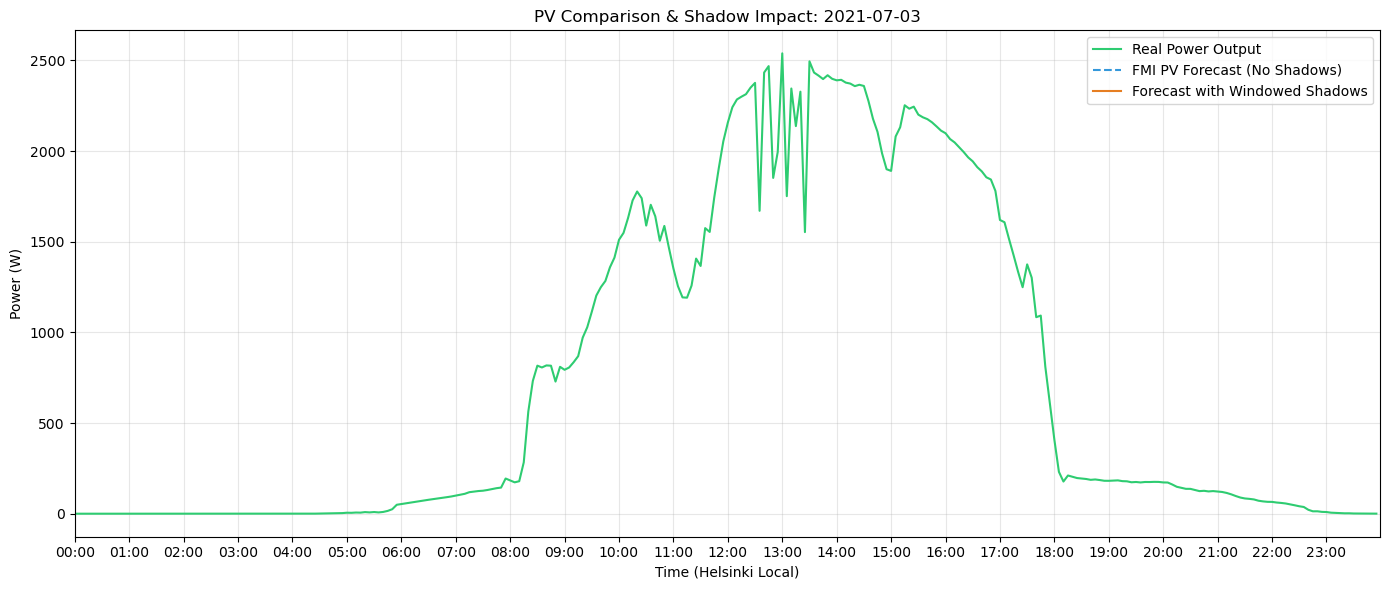

In [25]:
day_data, forecast_base, forecast_windowed = pv_analysis(target_date=clear_days['Date'].iloc[0], shadow_matrix_df=shadow_matrix_df, excel_df=pv_df, df_extra=extra_data_df, window_size=20, plot=True)